In [1]:
import numpy  as np
import pandas as pd
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.misc import derivative
from   scipy import optimize
import astropy.units as u
#import astropy.constants as c
from   astropy.cosmology import FlatLambdaCDM, z_at_value
from   tqdm import *
from   sympy import *
from   astropy.cosmology import Planck13 as cosmo
from   astropy import constants as const

import sys
from   scipy.interpolate import interp1d
from   scipy.interpolate import interp2d
from   scipy.special import zeta
import pickle

import matplotlib.pyplot as plt
from   matplotlib import ticker
from matplotlib import gridspec
import matplotlib.pylab as pylab
#from matplotlib import colormaps
import matplotlib.ticker as mticker



import time

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, '../packages')

import units
import import_packages
from FIRAS import *
#importing generic constants and functions
from const_func_general import *
#importing distortion specific constants and functions
from cons_func_distortion import *
#importing functions actually calculatting distortion
from calc_distortion import *
#importing functions for maximum liklihood analysis 
# from max_likelihood_analysis import *


$P_{\gamma \rightarrow A'}$

Perturbative: 
\begin{equation}
P_{\gamma \rightarrow A'}(m_{A'},x) = \sum_\text{res} \frac{\pi \epsilon^2 m_{A'}^4}{ \omega(z_\text{res}) \cdot (1+z_\text{res}) H_\text{res} } \frac{1}{\left| d m_\gamma^2/dz \right|_\text{res}}.
\end{equation}

Non-perturbative: 
\begin{equation}
P_{\gamma \rightarrow A'}(m_{A'},x) = 1 - \exp\left(- \sum_\text{res} \frac{\pi \cdot \sin^2\epsilon \cdot m_{A'}^4}{ \omega(z_\text{res}) \cdot (1+z_\text{res}) H_\text{res} } \frac{1}{\left| d m_\gamma^2/dz \right|_\text{res}} \right)
\end{equation}
 Calc and interp: $z_\text{res}(m_{A'},x)$ and $P_{\gamma \rightarrow A'}(m_{A'},x)$                                                                                                              
                                                                                                              

In [2]:
# ----------------------------------------------------------------------
# Parameters for scanning in (mAp,x) plane
# Here we calculate P(A->Ap) for (mAp,x) plane. Result will be used later
# To interpolate probability for much faster calculations. 
# We have checked and error between interpolated and directly calcualted probability is negiligible.
# ----------------------------------------------------------------------
# Output the P(A->Ap) table on x-mAp plane
N_P_x   = 500
N_P_mAp = 300

nu_P_min = 10**(-2)  # in cm^-1
nu_P_max = 30        # in cm^-1    # Note: The highest nu_FIRAS is 21.33 cm^-1

x_P_min = 2 * np.pi * nu_P_min * cmInv_to_eV/TCMB_0   # in eV
x_P_max = 2 * np.pi * nu_P_max * cmInv_to_eV/TCMB_0   # in eV

mAp_P_min = 10**(-17)                               # in eV     # Note: The lower mAp of FIRAS bound is ~10^(-15) eV
mAp_P_max = 10**(-3)                                # in eV     # Note: mAp~10^-4eV, z_res~10^6 (Double Compton Scattering). 


print('N_P_x     = ', N_P_x )
print('N_P_mAp   = ', N_P_mAp )
print('')
print('x_P_min   = ', x_P_min )
print('x_P_max   = ', x_P_max )
print('')
print('mAp_P_min = ', mAp_P_min, 'eV')
print('mAp_P_max = ', mAp_P_max, 'eV')
print('')

# ----------------------------------------------------------------------
# Scan in (x,mAp) plane
# ----------------------------------------------------------------------

x_P_scan_ary   = np.linspace( x_P_min, x_P_max, N_P_x )
mAp_P_scan_ary = np.logspace( np.log10(mAp_P_min), np.log10(mAp_P_max), N_P_mAp )

P_over_eps2_scan_2Dary = np.zeros( (len(x_P_scan_ary),len(mAp_P_scan_ary)) )

zres_scan_2Dary        = np.zeros( (len(x_P_scan_ary),len(mAp_P_scan_ary)) )

N_P_x     =  500
N_P_mAp   =  300

x_P_min   =  0.0052789483668742995
x_P_max   =  15.836845100622897

mAp_P_min =  1e-17 eV
mAp_P_max =  0.001 eV



In [62]:


for j in tqdm_notebook(range(0,len(mAp_P_scan_ary))):

    
    for i in range(0,len(x_P_scan_ary)):
        
        x_i   = x_P_scan_ary[i]
        mAp_j = mAp_P_scan_ary[j]   # in eV
        
        get_z_crossing_ij = get_z_crossings(mAp_j,TCMB_0*x_i)
        
        # Check whether A and Ap crosses
        # If no crossing, choose zres=0
        if (len( get_z_crossing_ij ) > 0):
            zres_scan_2Dary[i][j] = get_z_crossing_ij[0]   # Only pick the smallest z_cross
        else:
            zres_scan_2Dary[i][j] = 0  # When there is no crossing
        
        # P_over_eps2_scan_2Dary[i][j] = P_over_eps2(mAp_j, x_i)
        P_over_eps2_scan_2Dary[i][j] = P_pre_over_eps2(mAp_j, x_i, get_z_crossing_ij)

In [184]:
# Exporting Probability and mAp and x_p values
np.savez("../data/Probability.npz",
         x_P_scan_ary=x_P_scan_ary,
         mAp_P_scan_ary=mAp_P_scan_ary,
         P_over_eps2_scan_2Dary=P_over_eps2_scan_2Dary,
         zres_scan_2Dary=zres_scan_2Dary
         )


In [38]:
# in this function you can pass which type of distortion to be used
#if nothing is passed mu_y_trans distortion with greens functions will be used

def I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy', dist_type='muy_trans' ):
    
    # this is distortion with greens functions
    if dist_type=='muy_trans':
            I0_dist_type=I0_dist_muy_trans( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    # this is free streaming distortion
    if dist_type=='freestreaming':
            I0_dist_type=I0( x_ary, T0_vary, units='MJy' ) * ( 1 - eps**2 * np.transpose( P_over_eps2_interp( m_Aprime, x_ary ) )[0] )    # in MJy/sr

    return I0_dist_type


def chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type='muy_trans'):
    
    # [[[Data]]]
    nu_ary = FIRAS_nu_ary  # in cm^-1
    
    # [[[Data]]]
    x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
    # <<<Use T0_vary>>>
    x_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
    # [[[Data]]]
    # I0 from FIRAS measurement
    I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
    # [[[Data]]]
    # Residual of FIRAS
    res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
    # [[[Data]]]
    # Uncertainty of FIRAS
    sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
    # <<<Use T0_vary>>>
    # I0 after distortion
    I0_dist_ary = I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, 'MJy', dist_type)
    #print(I0_dist_ary)
    # Difference between data and theory
    diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
    # chi^2
    # Here 10^6 change kJy/sr in Cov to MJy/sr
    chi_sq = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6
    
    return chi_sq


# ----------------------------------------------------------------------
# chi^2 with T0 minimization
# ----------------------------------------------------------------------
def chi_sq_minT0( x_prime_int, m_Aprime, eps, dist_type='muy_trans'):
    
    def chi_sq_T0vary(T0_vary):
        
        return chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type )
    
    # full outout of chi^2 minimization over T0
    

    chi_sq_minT0_full_output   = optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)

    
    T0_min_K     = chi_sq_minT0_full_output[0]/K
    
    chi_sq_minT0 = chi_sq_minT0_full_output[1]
    

    return chi_sq_minT0

def chi_sq_minT0_mineps( x_prime_int, m_Aprime, dist_type='muy_trans'):
    
    def chi_sq_minT0_log10epsvary( log10eps ):
        
        return chi_sq_minT0( x_prime_int, m_Aprime, 10**log10eps, dist_type )

    chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
   
    
    eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
    chi_sq_minT0_mineps = chi_sq_minT0_minlog10eps_full_output[1]
    
    return chi_sq_minT0_mineps



In [35]:
# # in this function you can pass which type of distortion to be used
# #if nothing is passed mu_y_trans distortion with greens functions will be used

# def I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy'):
    
#     # this is distortion with greens functions
   
#     #I0_dist_type=I0_dist_muy_trans( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
#     # this is free streaming distortion
#     I0_dist_type=I0( x_ary, T0_vary, units='MJy' ) * ( 1 - eps**2 * np.transpose( P_over_eps2_interp( m_Aprime, x_ary ) )[0] )    # in MJy/sr

#     return I0_dist_type

In [36]:



# def chi_sq( x_prime_int, m_Aprime, eps, T0_vary):
    
#     # [[[Data]]]
#     nu_ary = FIRAS_nu_ary  # in cm^-1
    
#     # [[[Data]]]
#     x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
#     # <<<Use T0_vary>>>
#     x_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
#     # [[[Data]]]
#     # I0 from FIRAS measurement
#     I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
#     # [[[Data]]]
#     # Residual of FIRAS
#     res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
#     # [[[Data]]]
#     # Uncertainty of FIRAS
#     sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
#     # <<<Use T0_vary>>>
#     # I0 after distortion
#     I0_dist_ary = I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, 'MJy')
#     #print(I0_dist_ary)
#     # Difference between data and theory
#     diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
#     # chi^2
#     # Here 10^6 change kJy/sr in Cov to MJy/sr
#     chi_sq = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6
    
#     return chi_sq


# # ----------------------------------------------------------------------
# # chi^2 with T0 minimization
# # ----------------------------------------------------------------------
# def chi_sq_minT0( x_prime_int, m_Aprime, eps):
    
#     def chi_sq_T0vary(T0_vary):
        
#         return chi_sq( x_prime_int, m_Aprime, eps, T0_vary )
    
#     # full outout of chi^2 minimization over T0
    

#     chi_sq_minT0_full_output   = optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)

    
#     T0_min_K     = chi_sq_minT0_full_output[0]/K
    
#     chi_sq_minT0 = chi_sq_minT0_full_output[1]
    

#     return chi_sq_minT0

# def chi_sq_minT0_mineps( x_prime_int, m_Aprime):
    
#     def chi_sq_minT0_log10epsvary( log10eps ):
        
#         return chi_sq_minT0( x_prime_int, m_Aprime, 10**log10eps )

#     chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
   
    
#     eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
#     chi_sq_minT0_mineps = chi_sq_minT0_minlog10eps_full_output[1]
    
#     return chi_sq_minT0_mineps



In [45]:
# free streming calculation
mAp_scan_min = 10**(-16) # in eV
mAp_scan_max = 10**(-3)  # in eV

eps_scan_min = 10**(-8)
eps_scan_max = 1
x_prime_int_test = np.logspace(-3,5,200)

Nscan_mAp = 350
Nscan_eps = 520

m_Ap_ary = np.logspace( np.log10(mAp_scan_min), np.log10(mAp_scan_max), Nscan_mAp )
eps_ary = np.logspace( np.log10(eps_scan_min), np.log10(eps_scan_max), Nscan_eps )


# 2D array: N_eps * N_mAp
TS_2Dary   = np.zeros((len(eps_ary),len(m_Ap_ary)))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# TS only with diagonal terms
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
   
    
    
    m_Ap_j   =  m_Ap_ary[j]
    
    #chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j )
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j, 'freestreaming')

    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        
        # print('This is ', i, 'th eps')

        eps_i   =  eps_ary[i]
        #TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i) - chi_sq_minT0_mineps_value

        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i,'freestreaming' ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        
        #print([mAp, eps, chisq])



In [46]:

# Exporting Probability and mAp and x_p values
np.savez("../data/freestreaming_FIRAS.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [47]:
#importing files
file_name = "../data/freestreaming_FIRAS.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
mAp_1Dary_import_freestreaming= file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
eps_1Dary_import_freestreaming = file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
TS_2Dary_import_freestreaming = file['TS_2Dary']



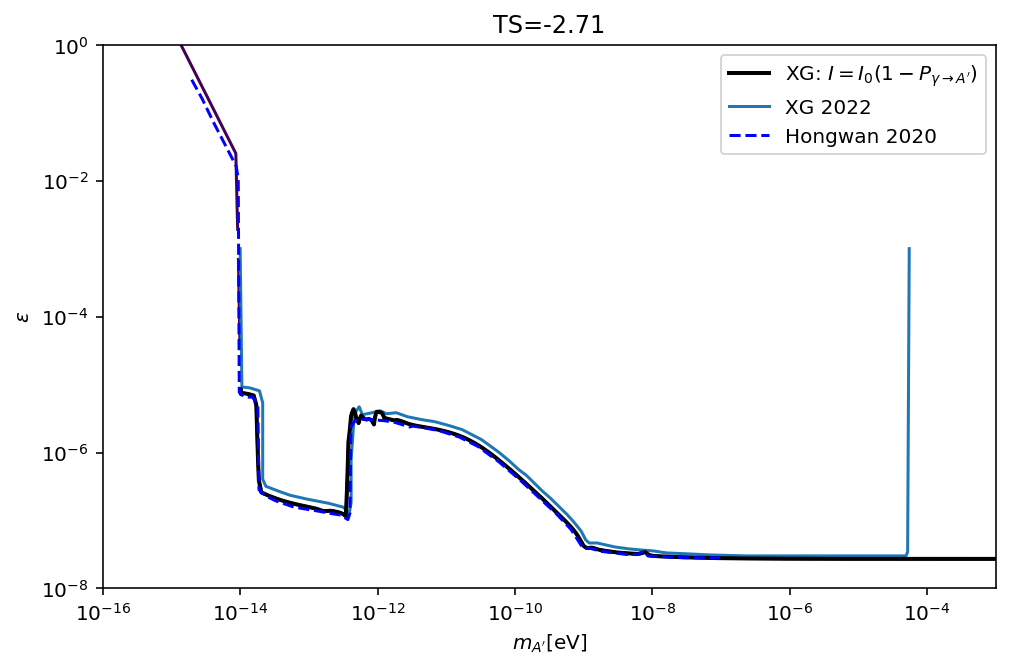

In [49]:
Xucheng_FIRAS_2Dary    = np.transpose( np.array( pd.read_csv('../data/Xucheng_22_FIRAS.csv') ) )
Samuel_FIRAS_2Dary     = np.transpose( np.array( pd.read_csv('../data/Samuel_20_FIRAS.csv') ) )
Hongwan_20_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/Hongwan_20_FIRAS.csv') ) )
Redondo_09_FIRAS_2Dary = np.transpose( np.array( pd.read_csv('../data/Redondo_09_FIRAS.csv') ) )


# Delta 95%CL, From PDG Statistics
# TS_choose = 5.99
TS_choose = 2.71

import matplotlib.cm as cm

X_plt, Y_plt     = np.meshgrid( mAp_1Dary_import_freestreaming, eps_1Dary_import_freestreaming )
Z_plt_M          = np.log10( TS_2Dary_import_freestreaming )

set_matplotlib_formats('retina')
plt.figure(figsize=(8,5))


plt.xscale('log')
plt.yscale('log')

CS_M  = plt.contour(X_plt, Y_plt, Z_plt_M,  levels = [ np.log10(TS_choose) ])


Xucheng_Greens_M  = np.transpose(CS_M.collections[0].get_paths()[0].vertices )

plt.plot( Xucheng_Greens_M[0]         , Xucheng_Greens_M[1], label = r'XG: $I=I_0 (1-P_{\gamma \rightarrow A^\prime})$', color='black',linewidth=2.0, zorder=5)
plt.plot( Xucheng_FIRAS_2Dary[0]      , Xucheng_FIRAS_2Dary[1], label = r'XG 2022')
plt.plot( Hongwan_20_FIRAS_2Dary[0]   , Hongwan_20_FIRAS_2Dary[1], label = r'Hongwan 2020', color = 'blue',linestyle = 'dashed', zorder=10)
# plt.plot( Redondo_09_FIRAS_2Dary[0] , Redondo_09_FIRAS_2Dary[1], label = r'Redondo 2009', color = 'red')

# plt.plot( Samuel_FIRAS_2Dary[0]     , Samuel_FIRAS_2Dary[1], label = r'Samuel 2020', color = 'orange')


plt.title(r'TS=-2.71')

plt.ylim(1e-8, 1)

plt.xlabel(r'$m_{A^\prime}$[eV]')
plt.ylabel(r'$\epsilon$')

plt.legend()
# plt.show()

plt.savefig('../plots/FIRAS_Bound_freestreaming.pdf')

### Scan $m_{A'}-\epsilon$ Plane


In [50]:
# x_prime_int_test = np.logspace(-4,2,1000)
# x_prime_int_test = np.logspace(-1,2,1000)
x_prime_int_test = np.logspace(-3,5,200)

# m_Ap_min = 10**(-10) # in eV
# m_Ap_max = 10**(-3)  # in eV
# eps_min  = 10**(-8)
# eps_max  = 10**(-3)
# N_m_Ap   = 50
# N_eps    = 70


m_Ap_min = 10**(-10) # in eV
m_Ap_max = 10**(-3)  # in eV
eps_min  = 10**(-8)
eps_max  = 10**2
N_m_Ap   = 50
N_eps    = 50


m_Ap_ary = np.logspace( np.log10(m_Ap_min), np.log10(m_Ap_max), N_m_Ap )
eps_ary  = np.logspace( np.log10(eps_min) , np.log10(eps_max) , N_eps  )


# 2D array: N_eps * N_mAp
TS_2Dary = np.zeros((len(eps_ary),len(m_Ap_ary)))

In [51]:



# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
   
    
    
    m_Ap_j   =  m_Ap_ary[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j )
    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        
        # print('This is ', i, 'th eps')

        eps_i   =  eps_ary[i]
        
        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        
        #print([mAp, eps, chisq])



In [52]:

# Exporting Probability and mAp and x_p values
np.savez("../data/transFIRAS_5p8e4_1p88.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [53]:
#importing files
file_name = "../data/transFIRAS_5p8e4_1p88.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
mAp_1Dary_import_5p8e4_1p88 = file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
eps_1Dary_import_5p8e4_1p88 = file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
TS_2Dary_import_5p8e4_1p88 = file['TS_2Dary']



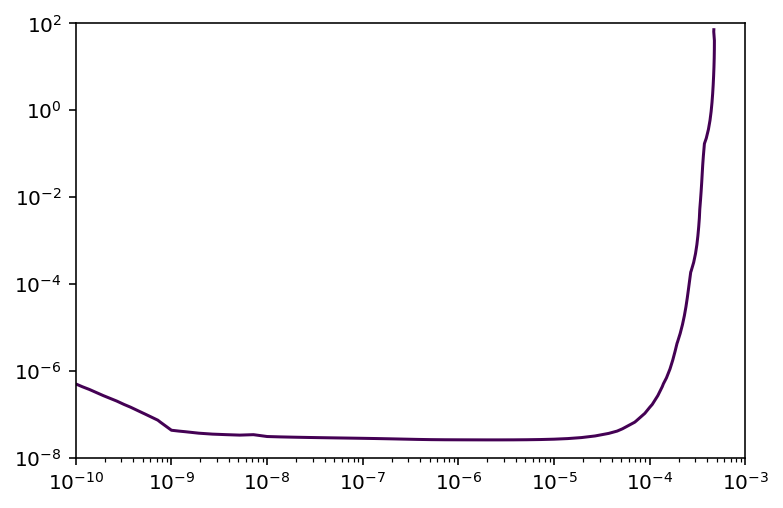

In [59]:
set_matplotlib_formats('retina')
plt.figure()

plt.xscale('log')
plt.yscale('log')


# Delta 95%CL, From PDG Statistics
# TS_choose = 5.99
TS_choose = 2.71

TS_Reg = 0.001

X_plt_5p8e4_1p88, Y_plt_5p8e4_1p88 = np.meshgrid( mAp_1Dary_import_5p8e4_1p88, eps_1Dary_import_5p8e4_1p88    )
Z_plt_5p8e4_1p88                   = np.log10(    TS_2Dary_import_5p8e4_1p88   + TS_Reg )
CS_trans_5p8e4_1p88=  plt.contour(X_plt_5p8e4_1p88, Y_plt_5p8e4_1p88, Z_plt_5p8e4_1p88,  levels = [ np.log10(TS_choose) ]);
Xucheng_Greens_trans_5p8e4_1p88 = np.transpose(CS_trans_5p8e4_1p88.collections[0].get_paths()[0].vertices );


Text(0.5, 0.94, '\\bf{COBE-FIRAS Constraints: $\\mathrm{TS}=-2.71$}')

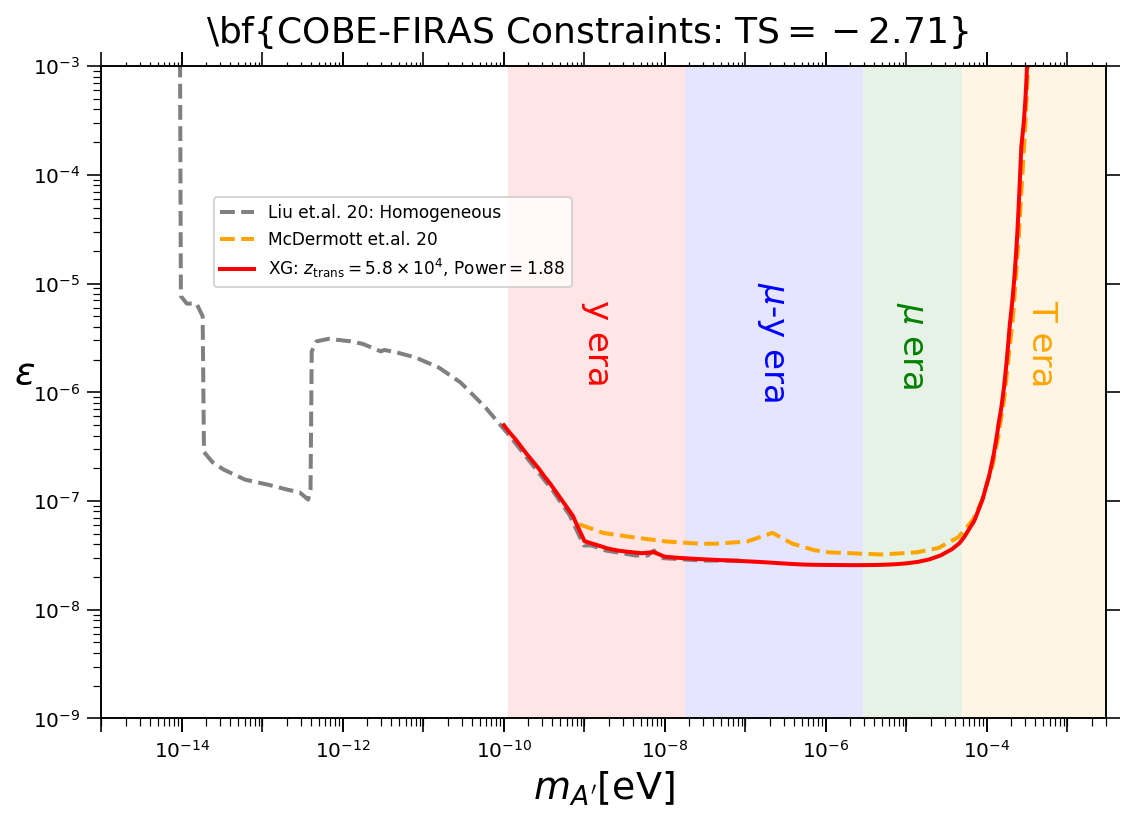

In [60]:
Xucheng_FIRAS_2Dary         = np.transpose( np.array( pd.read_csv('../data/Xucheng_22_FIRAS.csv') ) )
Samuel_FIRAS_2Dary          = np.transpose( np.array( pd.read_csv('../data/Samuel_20_FIRAS.csv') ) )
Redondo_09_FIRAS_2Dary      = np.transpose( np.array( pd.read_csv('../data/Redondo_09_FIRAS.csv') ) )
Hongwan_20_FIRAS_ho_2Dary   = np.transpose( np.array( pd.read_csv('../data/Hongwan_20_FIRAS_ho.csv') ) )
Hongwan_20_FIRAS_inho_2Dary = np.transpose( np.array( pd.read_csv('../data/Hongwan_20_FIRAS_inho.csv') ) )


# ====================================================
# Plot Parameters
mAp_pltmin = 1e-15 # eV
mAp_pltmax = 3e-3  # eV

eps_pltmin = 1e-9
eps_pltmax = 1e-3

majortick_len = 7 # length of major tick
minortick_len = 4 # length of minor tick

twin_majortick_len = majortick_len  # length of twin major tick
twin_minortick_len = minortick_len  # length of twin minor tick
# ====================================================



# Boundary of mu-y transition era
z_trans_0   = 10**3
z_trans_1   = 10**4
z_trans_2   = 3 * 10**5
z_dcs       = 2 * 10**6  # Redshif of double Compton scattering
z_max       = 10**10   # We just choose some very large z_max value

mAp_trans_0 = np.sqrt( mAsq(z_trans_0, 0) ) # in eV
mAp_trans_1 = np.sqrt( mAsq(z_trans_1, 0) ) # in eV
mAp_trans_2 = np.sqrt( mAsq(z_trans_2, 0) ) # in eV
mAp_dcs     = np.sqrt( mAsq(z_dcs, 0) )     # in eV
mAp_max     = np.sqrt( mAsq(z_max, 0) )     # in eV


# Delta 95%CL, From PDG Statistics
# TS_choose = 5.99
TS_choose = 2.71

TS_Reg = 0.001


fig, ax = plt.subplots()

ax1 = ax.twiny()

fig.set_size_inches(9, 6)

ax.set_xscale('log')
ax.set_yscale('log')
ax1.set_xscale('log')    # twin_y axis
ax1.set_yscale('log')    # twin_y axis

ax.set_xlim(mAp_pltmin, mAp_pltmax)
ax.set_ylim(eps_pltmin, eps_pltmax)
ax1.set_xlim(mAp_pltmin, mAp_pltmax)    # twin_y axis
ax1.set_ylim(eps_pltmin, eps_pltmax)    # twin_y axis

#ax.plot( Xucheng_FIRAS_2Dary[0]    , Xucheng_FIRAS_2Dary[1], label = r'Gan et.al. 2022')
ax.plot( Hongwan_20_FIRAS_ho_2Dary[0] , Hongwan_20_FIRAS_ho_2Dary[1], linewidth=2, label = r'Liu et.al. 20: Homogeneous', color = 'gray', linestyle = 'dashed')
# ax.plot( Redondo_09_FIRAS_2Dary[0] , Redondo_09_FIRAS_2Dary[1], label = r'Redondo et.al. 2009', color = 'red')
ax.plot( Samuel_FIRAS_2Dary[0]     , Samuel_FIRAS_2Dary[1], linewidth=2, label = r'McDermott et.al. 20', color = 'orange', linestyle = 'dashed')

ax.plot( Xucheng_Greens_trans_5p8e4_1p88[0], Xucheng_Greens_trans_5p8e4_1p88[1], label = r'XG: $z_\mathrm{trans} = 5.8 \times 10^4$, $\mathrm{Power}=1.88$', color='red',  linewidth=2.0)


ax.axvspan(mAp_trans_1, mAp_trans_2, alpha=0.1, facecolor='blue', edgecolor=None)
ax.text(1.3e-7, 1e-6, r'$\mu$-y era', fontsize=17, color='blue', rotation=-90)

ax.axvspan(mAp_trans_0, mAp_trans_1, alpha=0.1, facecolor='red', edgecolor=None)
ax.text(0.9e-9, 1.3e-6, r'y era', fontsize=17, color='red', rotation=-90)

ax.axvspan(mAp_trans_2, mAp_dcs, alpha=0.1, facecolor='green', edgecolor=None)
ax.text(7e-6, 1.3e-6, r'$\mu$ era', fontsize=17, color='green', rotation=-90)

ax.axvspan(mAp_dcs, mAp_max, alpha=0.1, facecolor='orange', edgecolor=None)
ax.text(3e-4, 1.3e-6, r'T era', fontsize=17, color='orange', rotation=-90)


ax.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=100) )
ax.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))

ax.tick_params(which='major', length=majortick_len, labelbottom=True)
ax.tick_params(which='minor', length=minortick_len, labelbottom=False)

ax.tick_params(axis='both', left=True, top=True, right=True, bottom=True, labelleft=True, labeltop=False, labelright=False, labelbottom=True)


plt.setp(ax.xaxis.get_ticklabels(), rotation=0)

ax.set_xlabel(r'$m_{A^\prime}$[eV]',fontsize=19)
ax.set_ylabel(r'$\epsilon$',fontsize=19, rotation=0)

ax1.xaxis.set_major_locator( mticker.LogLocator(numticks=999, base=10) )
ax1.xaxis.set_minor_locator( mticker.LogLocator(numticks=999, base=10,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9)))

ax1.tick_params(which='major', length=twin_majortick_len)
ax1.tick_params(axis='both', left=False, top=True, right=False, bottom=True, labelleft=False, labeltop=False, labelright=False, labelbottom=False)


ax.legend(bbox_to_anchor=(0.29, 0.73), loc = 'center',fontsize=8.5)
fig.suptitle(r"\bf{COBE-FIRAS Constraints: $\mathrm{TS}=-2.71$}", y=0.94, fontsize=18)

#plt.savefig('../plots/mAp_eps_plt_2.pdf')